# Project 6
# Submitted By: Prateek Kumar

# Problem 1

Automatically created module for IPython interactive environment


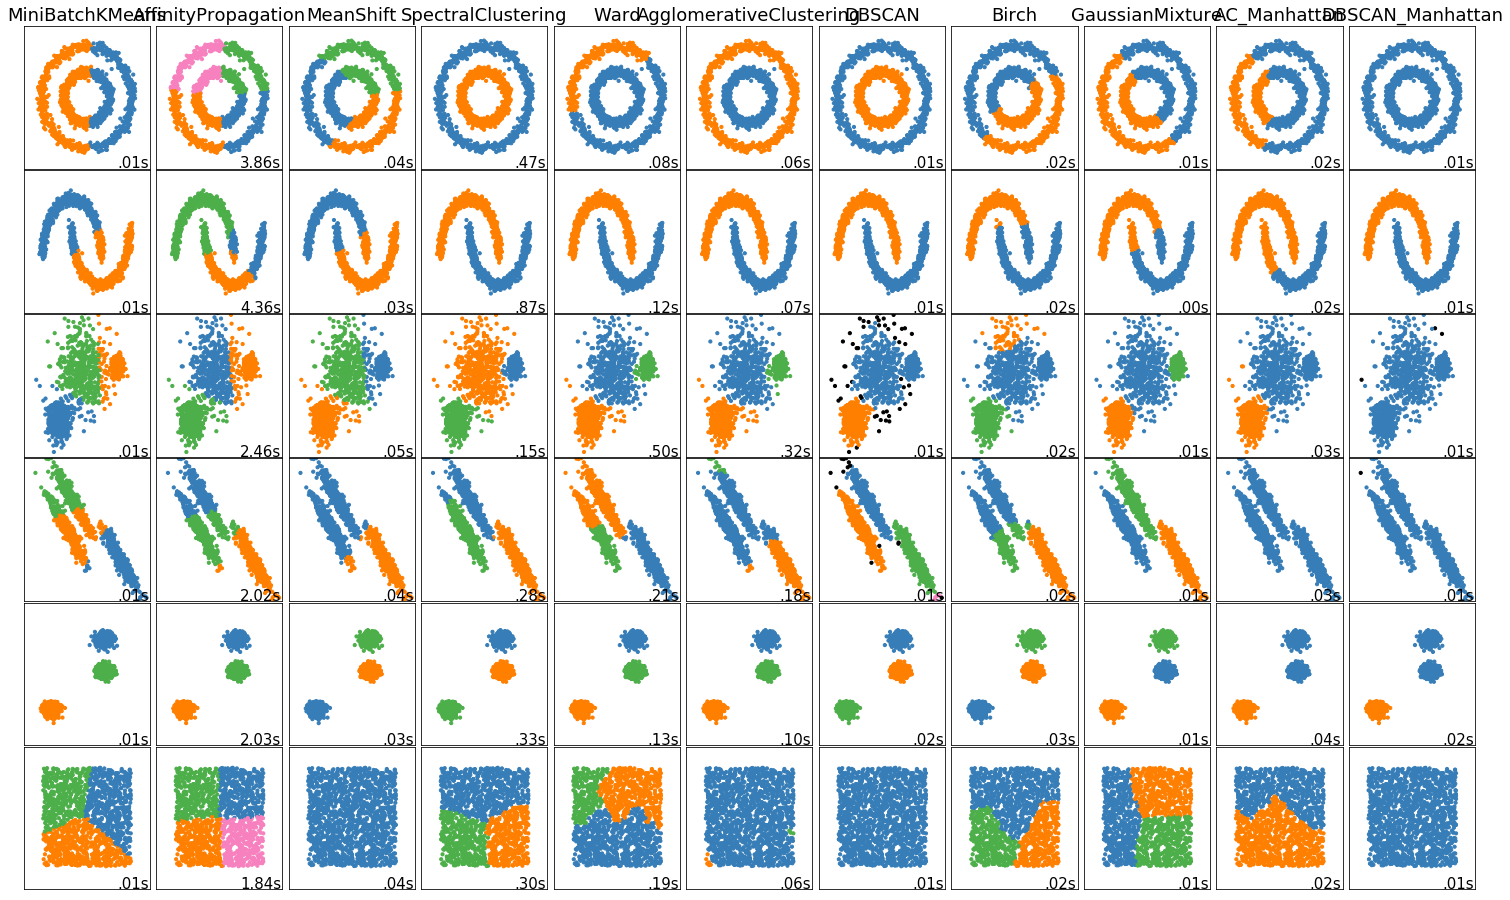

In [21]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    #agglomerative clustering using manhattan distance
    man_1 = cluster.AgglomerativeClustering(linkage="average", affinity="manhattan")
    #DBSCAN using manhattan distance
    man_2 = cluster.DBSCAN(metric="manhattan")

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('AC_Manhattan', man_1),
        ('DBSCAN_Manhattan', man_2)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Here I calculated agglomerative clustering and DBSCAN clustering using manhattan distance and added the columns to the end of the above images plot.

Comparing between both the agglomerative clustering
We see that the clustering done with the manhattan distance is different from the previous agglomerative clustering. 

1. For make_circles, in the previous clustering we get both different colors for both the clusters so it correctly separates both the clusters but while using manhattan distance parts of both the circles are divided into different clusters which is improper.

2. For make_moons, we have both the moons in different clusters for the previous result and while calculating with the manhattan distance a part of one moon comes under the other cluster, so the agglomerative cluster generated with the manhattan distance does not divide the datapoints to separate clusters.

3. For make_blobs as well we can see some black points in the previous clustering but in manhattan distance agglomerative clustering it divides those points into the separate clusters as well.



And we can also observe that the manhattan distance agglomerative clustering takes slightly greater time than the general aggomerative clustering.


Now, comparing between both the DBSCAN results
Here as well we see that the clustering done with the manhattan distance is different from the previous DBSCAN clustering. 

1. For make_circles, in the previous clustering we get both different colors for both the clusters so it correctly separates both the clusters but while using manhattan distance we get just one cluster for both the circles. So manhattan distance DBSCAN is not able to separate the points into the clusters.

2. For make_moons, we have both the moons in different clusters for the both results. So the general DBSCAN and DBSCAN with manhattan distance both correctly classifies the clusters for the datapoints.

3. For make_blobs as well we can see that all the points are into the same cluster hence DBSCAN with manhattan distance fails to cluster the points in this case as well.

Here we can observe that the manhattan distance agglomerative clustering takes almost similar time as the general aggomerative clustering.

# Problem 2

# Autoencoding

An autoencoder is a kind of artificial neural network used to learn proficient information codings in an unsupervised way. The point of an autoencoder is to take in a portrayal for an arrangement of information, ordinarily for dimensionality reduction. The autoencoder idea is generally utilized for learning generative models of data. 

An autoencoder figures out how to pack information from the information layer into a short code, and after that uncompress that code into something that intently coordinates the first information. This powers the autoencoder to take part in dimensionality decrease, for instance by figuring out how to disregard noise. A few structures utilize stacked sparse autoencoder layers for image acknowledgment. 

The main autoencoder may figure out how to encode simple highlights like dots, the second to break down the principal layer's yield and after that encode less nearby highlights like the tip of the front light, the third may encode an entire fog light, and so on., until the last autoencoder encodes the entire picture into a code that matches e.g. the idea of "car". An elective utilize is as a generative model: for instance, if a framework is physically bolstered the codes it has learned for "car" and "flying", it might endeavor to produce a picture of a flying car, regardless of whether it has never observed a flying car.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.1


In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

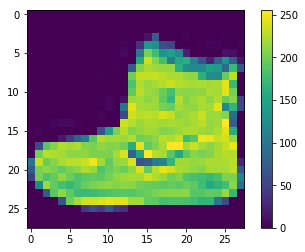

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [6]:
train_images = train_images / 255.0

test_images = test_images / 255.0

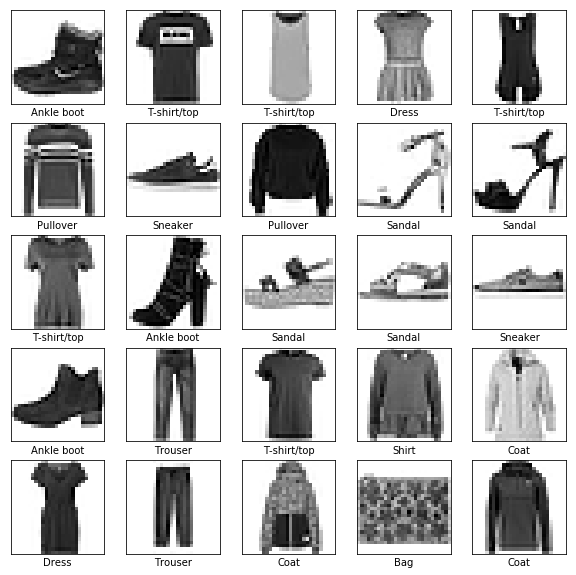

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [8]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [9]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 54us/step - loss: 0.4963 - acc: 0.8262
Epoch 2/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.3699 - acc: 0.8669
Epoch 3/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.3339 - acc: 0.8792
Epoch 4/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.3097 - acc: 0.8856
Epoch 5/5
60000/60000 [==============================] - 2s 28us/step - loss: 0.2927 - acc: 0.8918


In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 14us/step
('Test accuracy:', 0.8767)


In [12]:
predictions = model.predict(test_images)

In [13]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

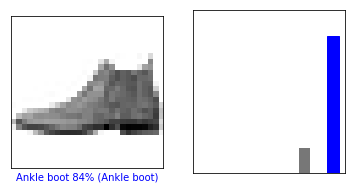

In [14]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

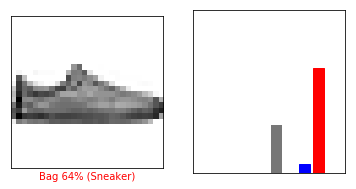

In [15]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

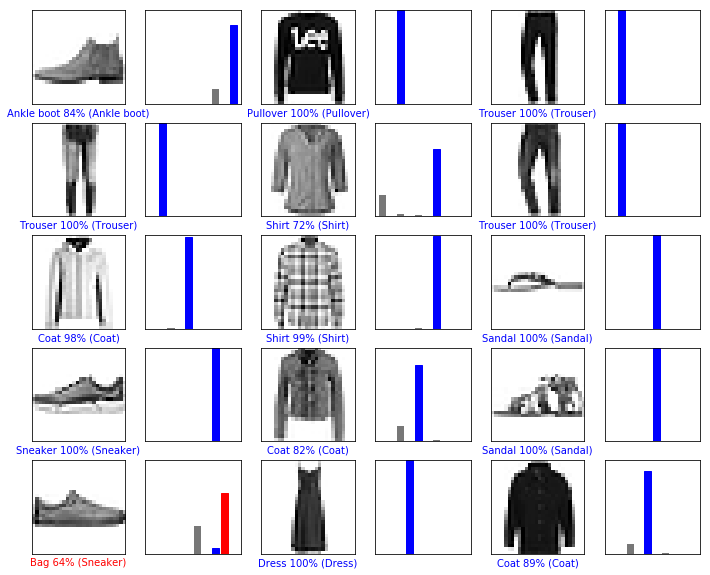

In [16]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [17]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)


predictions_single = model.predict(img)

print(predictions_single)

(28, 28)
(1, 28, 28)
[[2.0561325e-05 5.9529793e-06 9.1824922e-06 2.6550142e-06 2.7484862e-06
  3.5084451e-03 2.6985885e-05 1.5444754e-01 1.2345334e-03 8.4074140e-01]]


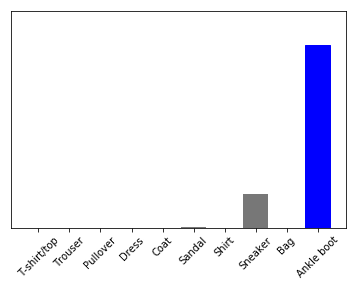

In [18]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [19]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=9, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(train_images[:,1,:])

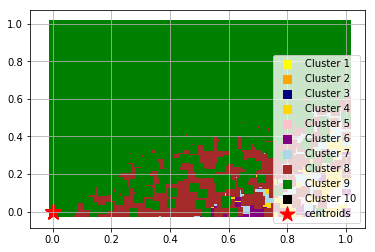

In [20]:
# Use scatter plot matrix to visualize the samples and the centroids
plt.scatter(train_images[y_km==0,0],train_images[y_km==0,1],s=50,c='yellow',marker='s',label='Cluster 1')
plt.scatter(train_images[y_km==1,0],train_images[y_km==1,1],s=50,c='orange',marker='s',label='Cluster 2')
plt.scatter(train_images[y_km==2,0],train_images[y_km==2,1],s=50,c='navy',marker='s',label='Cluster 3')
plt.scatter(train_images[y_km==3,0],train_images[y_km==3,1],s=50,c='gold',marker='s',label='Cluster 4')
plt.scatter(train_images[y_km==4,0],train_images[y_km==4,1],s=50,c='pink',marker='s',label='Cluster 5')
plt.scatter(train_images[y_km==5,0],train_images[y_km==5,1],s=50,c='purple',marker='s',label='Cluster 6')
plt.scatter(train_images[y_km==6,0],train_images[y_km==6,1],s=50,c='lightblue',marker='s',label='Cluster 7')
plt.scatter(train_images[y_km==7,0],train_images[y_km==7,1],s=50,c='brown',marker='s',label='Cluster 8')
plt.scatter(train_images[y_km==8,0],train_images[y_km==8,1],s=50,c='green',marker='s',label='Cluster 9')
plt.scatter(train_images[y_km==9,0],train_images[y_km==9,1],s=50,c='black',marker='s',label='Cluster 10')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.show()
plt.figure.figsize= (60,32)